# Hate Speech Classification

In [7]:
pwd

'/Users/shehbazpatel/Documents/Ineuron_Projects/NLP/HateSpeechClassification/notebook'

### Import the necessary libraries

In [2]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shehbazpatel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
### Read the data

In [9]:
imbalance_data = pd.read_csv("imbalanced_data.csv")

In [10]:
imbalance_data.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


---
### EDA

<Axes: xlabel='label', ylabel='count'>

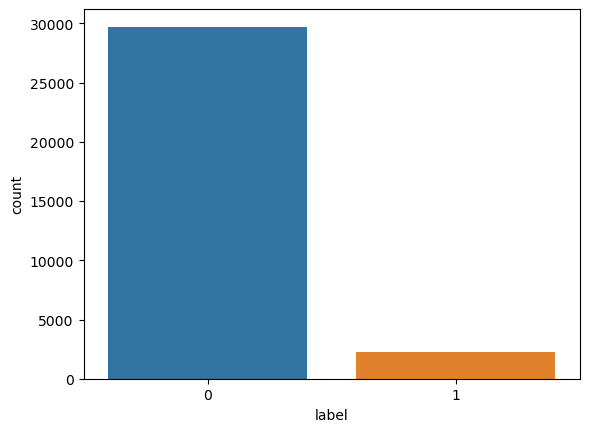

In [11]:
sns.countplot(x='label',data =imbalance_data)

From the above plot we can see that classes are imbalanced, we will fix it later.

In [14]:
# Checking the shape of the data
imbalance_data.shape

(31962, 3)

In [15]:
# Cheking if null values are present in the dataset or not.
imbalance_data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [16]:
# Let's drop the 'id' column as it is not required.
imbalance_data.drop('id',axis=1, inplace =True)

In [17]:
# Let's load another dataset similar to our dataset, since we want to fix the imbalance data.
raw_data = pd.read_csv("raw_data.csv")

In [18]:
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [19]:
raw_data.shape

(24783, 7)

In [20]:
raw_data.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [21]:
# Let's drop the columns which are not required for us.
raw_data.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace =True)

In [22]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [23]:
# Let's check for the unique values in the dataset
raw_data['class'].unique()

array([2, 1, 0])

<Axes: xlabel='class', ylabel='count'>

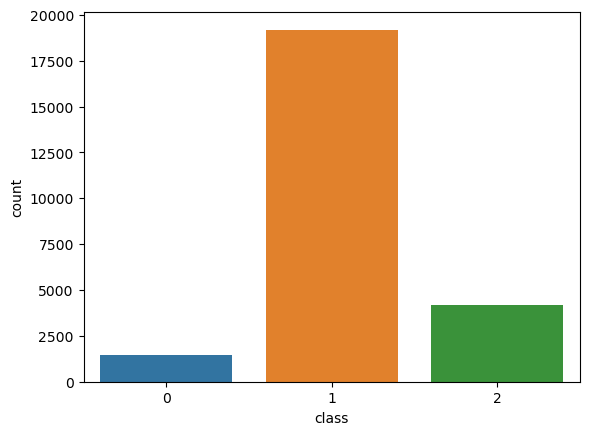

In [24]:
# Plotting the countplot for our new dataset
sns.countplot(x='class',data =raw_data)

- class 0: hate, class 1: abusive, and class 2: no hate.
- Let's copy the valus of the class 1 into class 0.

In [25]:
raw_data[raw_data['class']==0]['class']=1

/var/folders/h4/nbf_1jgn4mngsc4mrljyt9xr0000gn/T/ipykernel_71348/3600235578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[raw_data['class']==0]['class']=1


In [26]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [27]:
raw_data['class'].unique()

array([2, 1, 0])

In [ ]:
# Let's check the values in the class 0
raw_data[raw_data['class']==0]

In [29]:
# replace the value of 0 to 1
raw_data["class"].replace({0:1},inplace=True)

In [30]:
raw_data["class"].unique()

array([2, 1])

<Axes: xlabel='class', ylabel='count'>

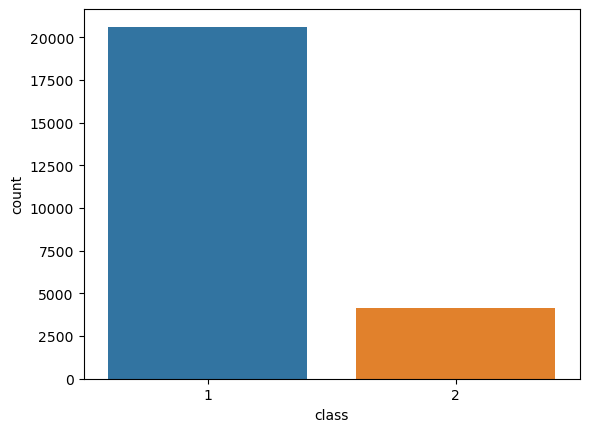

In [31]:
sns.countplot(x="class",data= raw_data)

In [32]:
# Let's replace the value of 2 to 0.
raw_data["class"].replace({2:0}, inplace = True)

<Axes: xlabel='class', ylabel='count'>

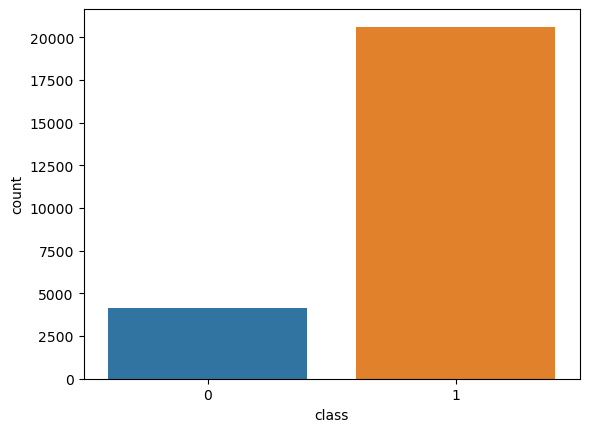

In [33]:
sns.countplot(x='class',data=raw_data)

In [34]:
# Let's change the name of the 'class' to label
raw_data.rename(columns={'class':'label'},inplace =True)

In [35]:
raw_data.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [36]:
raw_data.iloc[0]['tweet']

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [37]:
# Let's concatinate both the data into a single data frame.
frame = [imbalance_data, raw_data]
df = pd.concat(frame)

In [38]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


<Axes: xlabel='label', ylabel='count'>

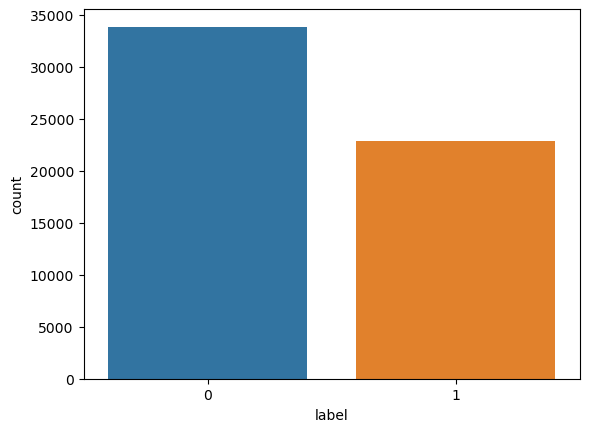

In [39]:
sns.countplot(x='label',data=df)

Now we can see that the problem of imbalace data has been solved.

In [42]:
df.shape

(56745, 2)

In [43]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [44]:
# Let's apply regex and do cleaning. 
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [45]:
# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

In [46]:
df["tweet"][3]

3    model   i love u take with u all the time in urð± ðððð
ð¦ð¦ð¦   model   i love u take with u all the time in urð± ðððð
ð¦ð¦ð¦   model   i love u take with u all the time in urð± ðððð
ð¦ð¦ð¦   mo...
3     rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cganderson vivabased she look like a tranni  rt cgander...
Name: tweet, dtype: object

In [47]:
df.head(10)

,label,tweet
0,0,user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run user when a father is dysfunctional and is so self...
1,0,user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthank user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthank user user thanks for lyft...
2,0,bihday your majesti bihday your majesti bihday your majesti bihday your majesti bihday your majesti
3,0,model i love u take with u all the time in urð± ðððð ð¦ð¦ð¦ model i love u take with u all the time in urð± ðððð ð¦ð¦ð¦ model i love u take with u all the time in urð± ðððð ð¦ð¦ð¦ mo...
4,0,factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society now motiv factsguide society ...
5,0,huge fan fare and big talking before they leave chaos and pay disputes when they get there allshowandnogo huge fan fare and big talking before they leave chaos and pay disputes when they get there allshowandnogo huge fan fare and big talking be...
6,0,user camping tomorrow user user user user user user user dannyâ¦ user camping tomorrow user user user user user user user dannyâ¦ user camping tomorrow user user user user user user user dannyâ¦ user camping tomorrow user user user user user us...
7,0,the next school year is the year for examsð¯ cant think about that ð­ school exams hate imagine actorslife revolutionschool girl the next school year is the year for examsð¯ cant think about that ð­ school exams hate imagine actorslife rev...
8,0,we won love the land allin cavs champions cleveland clevelandcavaliers â¦ we won love the land allin cavs champions cleveland clevelandcavaliers â¦ we won love the land allin cavs champions cleveland clevelandcavaliers â¦ we won love the land...
9,0,user user welcome here im its so user user welcome here im its so user user welcome here im its so user user welcome here im its so user user welcome here im its so user user welcome here im its so user...


In [48]:
x = df['tweet']
y = df['label']

In [49]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

42558 42558
14187 14187


In [50]:
type(x_test), type(y_test), type(x_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [51]:
len(x_test)

14187

In [52]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [53]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# Define the early stopping callback
stop = EarlyStopping(monitor='val_loss', patience=3)

# Define the model checkpoint callback
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
# starting model training
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 1,
                   validation_split=0.2,callbacks=[stop,checkpoint])

266/266 [==============================] - 211s 790ms/step - loss: 0.2814 - accuracy: 0.8905 - val_loss: 0.1838 - val_accuracy: 0.9320


/Users/shehbazpatel/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [57]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

444/444 [==============================] - 31s 69ms/step - loss: 0.1886 - accuracy: 0.9244


In [58]:
lstm_prediction = model.predict(test_sequences_matrix)

444/444 [==============================] - 30s 68ms/step


In [59]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)
        

In [60]:
print(confusion_matrix(y_test,res))

[[8006  447]
 [ 625 5109]]


In [61]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
# Let's save the mdoel.
model.save("model.h5")

In [54]:
import keras

In [55]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [56]:
# Let's test our model on custom data.
test = 'humans are idiots'
def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
test=[clean_text(test)]
print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = load_model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")
    

humans are idiots
humans are idiots
['human idiot']
[[939, 1600]]
1/1 [==============================] - 0s 363ms/step
pred [[0.21682839]]
no hate
